In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 180 (delta 80), reused 130 (delta 43), pack-reused 0
Receiving objects: 100% (180/180), 28.69 MiB | 29.47 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=b88fc718fa97b3ec9fe3fd08cef2898efe9de2181805840034a42a4a45bdb0c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-iszzyxf8/wheels/55/59/29/0fb1c63565215773

In [33]:
from dul_2021.utils.hw4_utils import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torch.optim as opt
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
from torch.distributions import MultivariateNormal
from torch.distributions.beta import Beta

import copy

from scipy.stats import norm
from scipy.optimize import bisect
from tqdm import trange, tqdm_notebook

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
!pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint
import torchdiffeq

# Question 1: 2D Data


Dataset 1


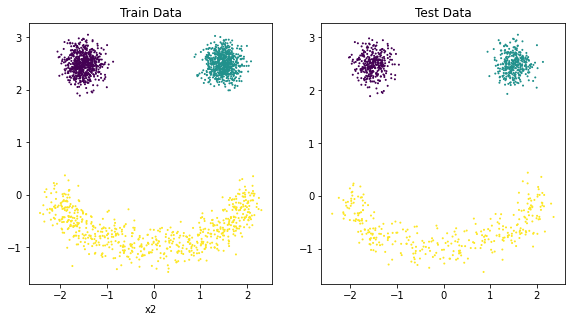

Dataset 2


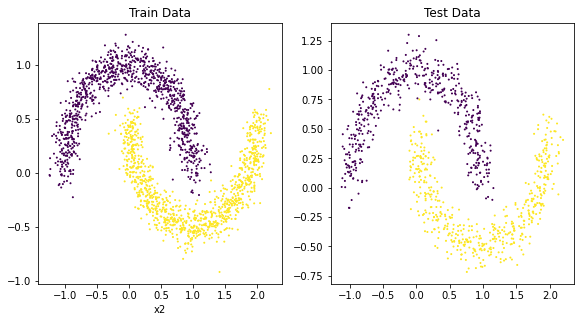

In [6]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Continious Normalazing Flow

Implement continious normalazing flow from [here](https://arxiv.org/pdf/1806.07366.pdf) (botom of page 4). We will be using following transformation parametrization of $\frac{dz(t)}{dt}$:

$\frac{dz(t)}{dt} = u \tanh(\omega^t z(t) + b) \Rightarrow \frac{\partial \log p(z(t))}{\partial z} = - u^t \frac{\partial h}{\partial z}$


Here $\omega, u$ have same dim as $z$ and $b$ is a scalar.

Parametrize $u, \omega, b$ with neural network with single input t. You may find it useful to icrease the 'width' of tansformation by performing m transformation and then averaging them.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model
* Show a heatmap of the densities learned by your model
* Show what the training set looks like when mapped to the latent space.

## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.



In [26]:
def device():
    return "cuda" if torch.cuda.is_available() else "cpu"

# сильно основано на этом, т.к. понял 5% от того что надо сделать и как и зачем вообще и почему
# дифур вижу второй раз в жизни, первый на лекции кек, на числаках мы матрички обращали
# https://github.com/rtqichen/torchdiffeq/blob/5a819e471c15cac5e4ec97a0e472b1569a1a872b/examples/cnf.py
class CNF(nn.Module):
    def __init__(self, out_dim, hidden_dim, width, tol=1e-5):
        super().__init__()

        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.tol = tol

        self.odefunc = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2 * width * out_dim + width)  # 2 for u, w, + 1 for b
        )

        self.base_dist = MultivariateNormal(
            torch.zeros(out_dim, device=device()),
            torch.eye(out_dim, device=device())
        )

    def _get_uwb(self, t):
        out = self.odefunc(t.unsqueeze(0)).squeeze()

        u, w = torch.chunk(out[:2 * self.width * self.out_dim], 2)
        b = out[-self.width:]

        return (
            u.reshape(self.width, 1, self.out_dim),
            w.reshape(self.width, self.out_dim, 1),
            b.reshape(self.width, 1, 1)
        )

    def _get_dzdt(self, t, z):
        u, w, b = self._get_uwb(t)        

        z = z.unsqueeze(0).repeat(self.width, 1, 1)
        h = torch.tanh(z.matmul(w) + b)

        return h.matmul(u).mean(dim=0)

    def _get_dlogp_dt(self, f, z):
        # украл украденное
        # https://github.com/rtqichen/torchdiffeq/blob/5a819e471c15cac5e4ec97a0e472b1569a1a872b/examples/cnf.py#L66
        trace = torch.zeros(z.shape[0], device=device())

        for i in range(self.out_dim):
            trace -= torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0][:, i]

        return trace.reshape(z.shape[0], 1)

    @torch.enable_grad()
    def forward(self, t, states):
        z, _ = states
        z.requires_grad_(True)

        dz_dt = self._get_dzdt(t, z)
        dlogp_dt = self._get_dlogp_dt(dz_dt, z)

        return dz_dt, dlogp_dt

    def flow(self, z_1, t_0, t_1):
        dlogp_dt = torch.zeros((z_1.shape[0], 1), device=device())
        time = torch.tensor([t_1, t_0], device=device())

        z_t, mlog_det_t = odeint(
            self,
            (z_1, dlogp_dt),
            time,
            atol=self.tol,
            rtol=self.tol,
            method="dopri5"
        )
        return z_t[-1], -mlog_det_t[-1]

    def log_prob(self, batch, t_0, t_1):
        z, log_det = self.flow(batch, t_0, t_1)
        logp_z = self.base_dist.log_prob(z).reshape(batch.shape[0], 1)

        return logp_z + log_det

    def _loss(self, batch, t_0, t_1):
        return -self.log_prob(batch, t_0, t_1).mean()

    
    @torch.no_grad()
    def encode(self, x, t_0, t_1):
        z, _ = self.flow(x, t_0, t_1)
        return z.cpu().numpy()

    @torch.no_grad()
    def prob(self, x, t_0, t_1):
        log_prob = self.log_prob(x, t_0, t_1)
        return log_prob.exp().cpu().numpy()

    @torch.no_grad()
    def test(self, test_dataloader, t_0, t_1):
        self.eval()

        losses = []
        for batch in test_dataloader:
            batch = batch.to(device())
            losses.append(self._loss(batch, t_0, t_1).item())
        
        self.train()
        return np.mean(losses)

    def fit(self, train_dataloader, test_dataloader, t_0=0, t_1=10, epochs=20, lr=1e-3):
        loss_info = {"train": [], "test": [self.test(test_dataloader, t_0, t_1)]}

        optim = torch.optim.Adam(self.parameters(), lr=lr)

        for _ in trange(epochs, desc="Training"):
            for batch in train_dataloader:
                batch = batch.to(device())
                loss = self._loss(batch, t_0, t_1)

                loss_info["train"].append(loss.item())

                optim.zero_grad()
                loss.backward()
                optim.step()
            loss_info["test"].append(self.test(test_dataloader, t_0, t_1))

        loss_info["train"] = np.array(loss_info["train"])
        loss_info["test"] = np.array(loss_info["test"])

        return loss_info

In [24]:
def q1(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats in R^2
  test_data: An (n_test, 2) numpy array of floats in R^2
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (?,) of probabilities with values in [0, +infinity). 
      Refer to the commented hint.
  - a numpy array of size (n_train, 2) of floats in [0,1]^2. This represents 
      mapping the train set data points through our flow to the latent space. 
  """
  
  """ YOUR CODE HERE """
  model = CNF(train_data.shape[1], hidden_dim=32, width=3).to(device())
  
  train_data = torch.tensor(train_data, dtype=torch.float)
  test_data = torch.tensor(test_data, dtype=torch.float)

  train_dataloader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_dataloader = data.DataLoader(test_data, batch_size=128, shuffle=False)

  losses = model.fit(train_dataloader, test_dataloader, t_0=0.0, t_1=10.0, epochs=100, lr=1e-3)

  # heatmap
  dx, dy = 0.025, 0.025
  if dset_id == 1:  # face
      x_lim = (-4, 4)
      y_lim = (-4, 4)
  elif dset_id == 2:  # two moons
      x_lim = (-1.5, 2.5)
      y_lim = (-1, 1.5)
  
  y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                  slice(x_lim[0], x_lim[1] + dx, dx)
  ]

  mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
  mesh_xs = torch.tensor(mesh_xs, dtype=torch.float, device=device())

  probs = model.prob(mesh_xs, t_0=0.0, t_1=10.0)
  latents = model.encode(train_data.to(device()), t_0=0.0, t_1=10.0)

  return losses["train"], losses["test"], probs, latents

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



Training: 100%|██████████| 50/50 [11:25<00:00, 13.72s/it]


Final Test Loss: 1.6084


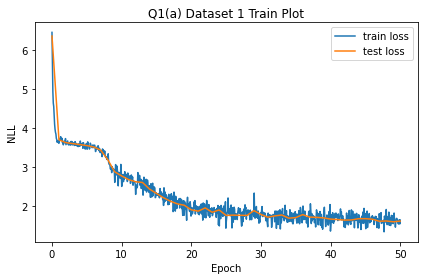

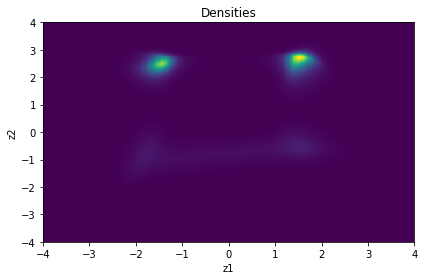

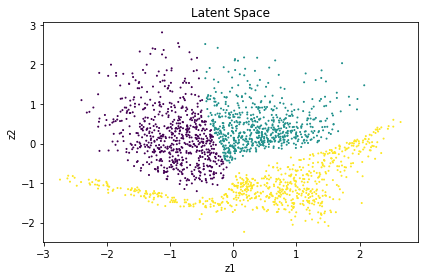

In [22]:
q1_save_results(1, 'a', q1)

Training: 100%|██████████| 100/100 [17:29<00:00, 10.50s/it]


Final Test Loss: 1.1892


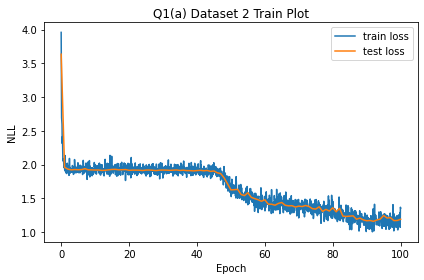

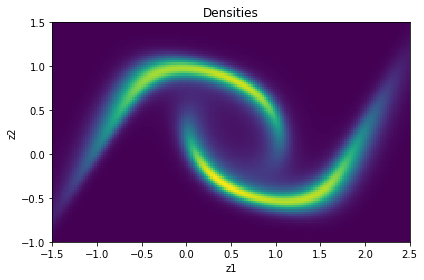

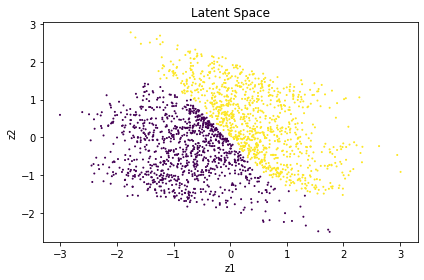

In [25]:
q1_save_results(2, 'a', q1)

# Question 2: Hutchinson's trace estimator

Implement CNF with Hutchinson trace estimator.

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [27]:
class HCNF(CNF):
    def _get_dlog_p_dt(self, f, z):
        v = 2 * torch.randint(0, 2, z.shape, dtype=torch.float, device=device()) - 1,
        A = torch.autograd.grad((v * f).sum(dim=(1, 0)), z)[0]
        trace = (A * v).sum(dim=1)

        return -trace.reshape(z.shape[0], 1)

In [30]:
def q2(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """
  model = HCNF(train_data.shape[1], hidden_dim=32, width=3, tol=1e-2).to(device())
  
  train_data = torch.tensor(train_data, dtype=torch.float)
  test_data = torch.tensor(test_data, dtype=torch.float)

  train_dataloader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_dataloader = data.DataLoader(test_data, batch_size=128, shuffle=False)

  losses = model.fit(train_dataloader, test_dataloader, t_0=0.0, t_1=10.0, epochs=100, lr=1e-3)

  return losses["train"], losses["test"]

### Results

Once you've implemented `q2`, execute the cells below to visualize and save your results



Training: 100%|██████████| 100/100 [51:48<00:00, 31.09s/it]


Final Test Loss: 12.3126


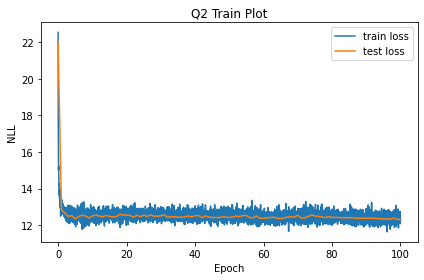

In [34]:
q2_save_results(q2)

# Bonus 3: CNF

Implement CNF with Hutchinson trace estimator and bottleneck trick

## You will provide these deliverables

* Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
* Report the final test set performance of your final model


## Solution

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def b3(train_data, test_data):
  """
  train_data: An (n_train, 10) numpy array of floats in R^10
  test_data: An (n_test, 10) numpy array of floats in R^10
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets, or
             for plotting a different region of densities

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  """
  
  """ YOUR CODE HERE """


### Results

Once you've implemented `b3`, execute the cells below to visualize and save your results



In [ ]:
q2_save_results(b3)